# K-means
Реализация алгоритма. На графиках красные точки показывают перемещение центров кластеров.

Следующий код задаёт случайные точки в окрестности трёх центров.

Steps:  5


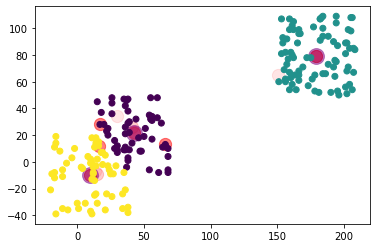

In [378]:
from random import randrange
from math import sqrt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

def generate_circles(center, count, k, dim=2, R=50):
    data = np.zeros((count, dim))

    for i in range(count):
        ind = randrange(k)
        data[i][0] = center[ind][0] + randrange(-R, R)
        data[i][1] = center[ind][1] + randrange(-R, R)
    return data

def random_choice(data, k, dim=2):
    size = np.size(data, 0)
    ind = np.random.choice(size, k)
    
    center = np.zeros((k, dim))
    center = data[ind]
    return center
 
def random_interval(data, k, dim=2):
    center = np.zeros((k, dim))
    for d in range(dim):
        center[:,d] = np.random.uniform(np.min(data[:,d]), np.max(data[:,d]), k)
    return center
    
def recalc_group_dist(data, center, k, C, dim=2):
    size = np.size(data, 0)
    
    for i in range(size):
        dst = np.zeros(k)
        for d in range(dim):
             dst += (center[:, d] - data[i][d])**2
        # d = (center[:, 0] - data[i][0])**2 + (center[:, 1] - data[i][1])**2
        C[i] = np.argmin(dst)
        
def recentroid(data, center, k, C, dim=2):
    size = np.size(data, 0)
    
    max_delta = 0.0
    delta = np.zeros(k)
    
    for i in range(k):
        for d in range(dim):
            # prev = center[:,d][i]
            prev = center[i][d].item()
            # center[:,d][i] = np.mean(data[:,d][C == i])
            center[i][d] = np.mean(data[:,d][C == i])
            # delta[i] += (prev - center[:, d][i])**2
            delta[i] += (prev - center[i][d])**2
        max_delta = max(max_delta, np.max(delta).item())
        
    return sqrt(max_delta)

def k_means(data, k, steps=100, eps=-1, dim=2, cent_init=random_choice):    
    size = np.size(data, 0)
    dim = np.size(data, 1)
    
    center = cent_init(data, k)
    # Cluster:
    C = np.zeros(size)
    
    cen_op = 0.1
    if(dim==2):
        plt.scatter(center[:, 0], center[:, 1], c='red', s=150, alpha=0.5)
    
    for i in range(steps):
        recalc_group_dist(data, center, k, C, dim=dim)
        if (recentroid(data, center, k, C, dim=dim)) < eps:
            break;
        if dim==2:
            plt.scatter(center[:, 0], center[:, 1], c='red', s=150, alpha=cen_op)
        cen_op += 0.1
        cen_op = min(1.0, cen_op)
    
    print("Steps: ", i + 1)
    if(dim==2):
        plt.scatter(center[:, 0], center[:, 1], c='purple', s=250, alpha=0.5)
    return C
    

dims = 2
size = 200
clust_count = 3

data = generate_circles(np.array([[10, -10], [40, 20], [180, 80]]), size, 3, R=30, dim=dims)

C = k_means(data, clust_count, eps=0.00001, cent_init=random_choice)
plt.scatter(data[:,0], data[:,1], c=C, alpha=1)
plt.show()

## Трёхмерный случай

Steps:  7


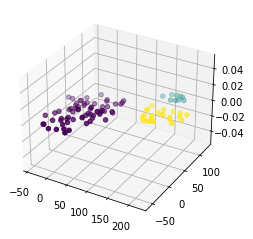

In [374]:
dims = 3
size = 100
clust_count = 3

data = generate_circles(np.array([[10, -10, 10], [40, 20, 100], [180, 80, 30]]), size, 3, R=50, dim=dims)
C = k_means(data, clust_count, eps=0.00001, cent_init=random_choice)

from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')

ax.scatter(data[:,0], data[:,1], data[:,2], c=C, cmap='viridis')
plt.show()

## Стратегия начальной инициализации
1. Выбор случайных точек, принадлежащих выборке
2. Выбор случайных точек из области, в которой лежат данные

При неудачной инициализации вторым методом, один из центров может оказаться слишком далеко от остальных точек, поэтому кластер будет пуст. Кроме того, этот метод не дал прироста в скорости нахождения центров кластеров.

Преимущества 1-го варианта:
- Невозможен случай совпадения точек
- Не приводит к созданию пустых кластеров

Из этих вариантов первый показал себя как более эффективный подход.

## Применение

K-means хорошо работает для данных, кластеры которых имеют сферическую форму, то есть похожих на некоторые "кучки". Также подходит для достаточно равномерно расположенных точек. Но этот алгоритм не подходит, ели точки принадлежат отдельным кривым.

Например, если точки лежат на двух дугах:

Steps:  5


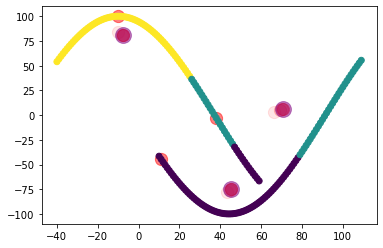

In [375]:
dims = 2
size = 200
clust_count = 3

data = np.random.rand(size//2, dims)
data[:,0] = np.arange(size//2)-40
data[:,1] = np.cos(np.arange(size//2)/30-1)*100
data2 = np.random.rand(size//2, dims)
data2[:,0] = np.arange(size//2)+10
data2[:,1] = np.cos(np.arange(size//2)/30+2)*100
data = np.vstack((data, data2))


C = k_means(data, clust_count, eps=0.00001, cent_init=random_choice)
plt.scatter(data[:,0], data[:,1], c=C, alpha=1)
plt.show()

## Стратегия выбора числа кластеров
Один из способов выбора количества кластеров - предположить, исходя из конкретной задачи. Далее проверить результаты для нескольких значений и выбрать наиболее правдоподобный.

Также можно последовательно увеличивать $k$ в заданных пределах, отслеживая изменение суммы растояний до центра от каждой точки кластера. Выбрать то значение $k$, при котором эта сумма минимальна.

## Скорость настройки
При увеличении количества точек или сложности, количество итераций увеличивается. Большое влияние оказывает "форма" распределения и начальные положения центров.

Steps:  23


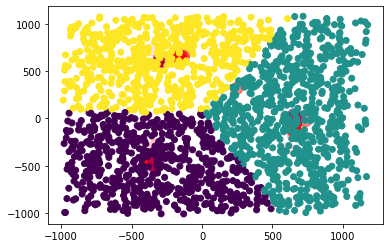

In [348]:
dims = 2
size = 2000
clust_count = 3

data = generate_circles(np.array([[10, -10, 10], [40, 20, 100], [180, 80, 30]]), size, 3, R=1000, dim=dims)
C = k_means(data, clust_count, eps=0.00001, cent_init=random_choice)
plt.scatter(data[:,0], data[:,1], c=C, alpha=1)
plt.show()

## Матрица попарных расстояний
В матрице точки в каждом кластере упорядочить в зависимости от расстояния до центроиды, а сами кластеры упорядочить по количеству элементов в них.